# Credit Card Fraud Detection Using Autoencoder
 - Algorithm: Autoencoder
 - Tool: PyTorch
 - Serialization:  ONNX
 - Deployment:  SAS Model Manager and SAS Intelligent Decisioning

## Declare required dependencies

In [1]:
# a = torch.ones(3,2)
# a_t = torch.transpose(a,0,1)
# a, a_t

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 111)
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Data ingestion

In [3]:
df = pd.read_csv('Data_orig/creditcard.csv')
customer_id = np.random.randint(1000000,5000000, len(df))
transaction_date = pd.date_range(start='1/1/2020', periods=len(df), freq='MIN') 
df.insert(0, 'customer_id', customer_id)
df.insert(1, 'transaction_date', transaction_date)


df.rename({'Time':'Counter'}, axis = 1, inplace = True)


dfsample = df.sample(frac=0.1)

dfsample.to_csv('Data_orig/creditcard_10.csv', index=False)
 

df.head()

,customer_id,transaction_date,Counter,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,3791747,2020-01-01 00:00:00,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1430573,2020-01-01 00:01:00,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2234988,2020-01-01 00:02:00,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1960808,2020-01-01 00:03:00,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,1515501,2020-01-01 00:04:00,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data exploration

- Variables V1 - V30 are Derived  Principal Components Analysis (PCA)

In [4]:
# df['Class'].value_counts()

In [5]:
print(df.shape)
print(df.describe())

(284807, 33)
        customer_id        Counter            V1            V2            V3  \
count  2.848070e+05  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05   
mean   3.000761e+06   94813.859575  1.759061e-12 -8.251130e-13 -9.654937e-13   
std    1.156158e+06   47488.145955  1.958696e+00  1.651309e+00  1.516255e+00   
min    1.000001e+06       0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01   
25%    1.999142e+06   54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01   
50%    3.002521e+06   84692.000000  1.810880e-02  6.548556e-02  1.798463e-01   
75%    4.002132e+06  139320.500000  1.315642e+00  8.037239e-01  1.027196e+00   
max    4.999977e+06  172792.000000  2.454930e+00  2.205773e+01  9.382558e+00   

                 V4            V5            V6            V7            V8  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   8.321385e-13  1.649999e-13  4.248366e-13 -3.054600e-13  8.777971e-14   
std    1.415869e+00  1.380247

## Is there any data missing ?

In [6]:
df.isnull().values.any()

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

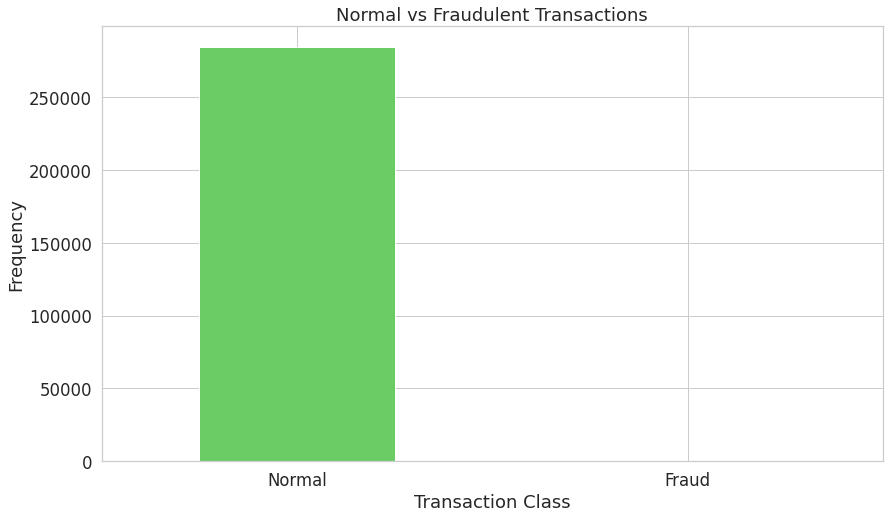

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulent Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Our dataset is very highly imbalanced in favour of negative(0, i.e normal) class. This requires further data exploration

In [8]:
fraudsDF = df[df.Class == 1]
normalDF = df[df.Class == 0]

fraudssample =fraudsDF.iloc[0:5].drop(['Class'], axis=1)
normalsample =normalDF.iloc[0:5].drop(['Class'], axis=1)

df_test=pd.concat([normalsample, fraudssample])

 
df_test.to_csv('Data_orig/creditcard_fraud_test_1.csv', index=False)



In [9]:
fraudsDF.shape

(492, 33)

In [10]:
normalDF.shape

(284315, 33)

Let's now look at the amount of money involved across two classes

In [11]:
fraudsDF.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normalDF.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
normalDF.Amount.max(), normalDF.Amount.min(), normalDF.Amount.value_counts()
print(normalDF['Amount']) 

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284315, dtype: float64


Graphically speaking ...`

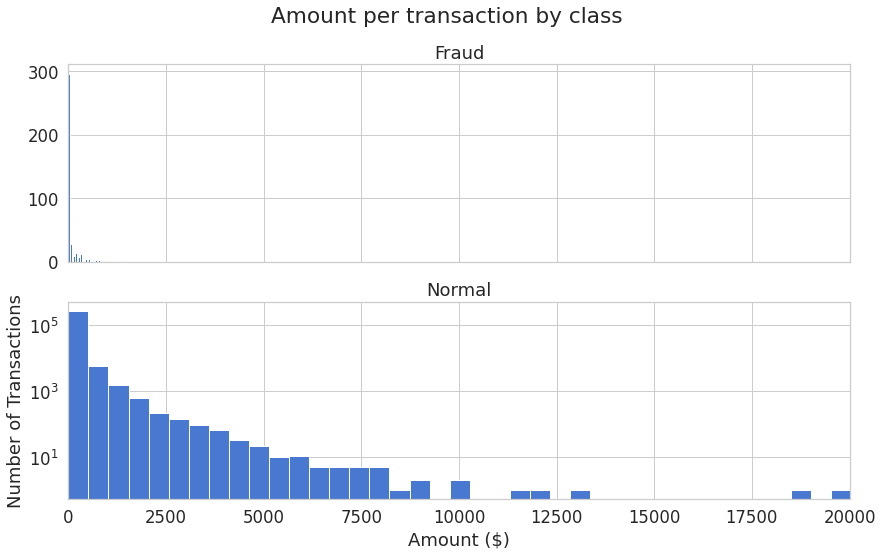

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Does time of transaction have any bearing on fraudulent activity

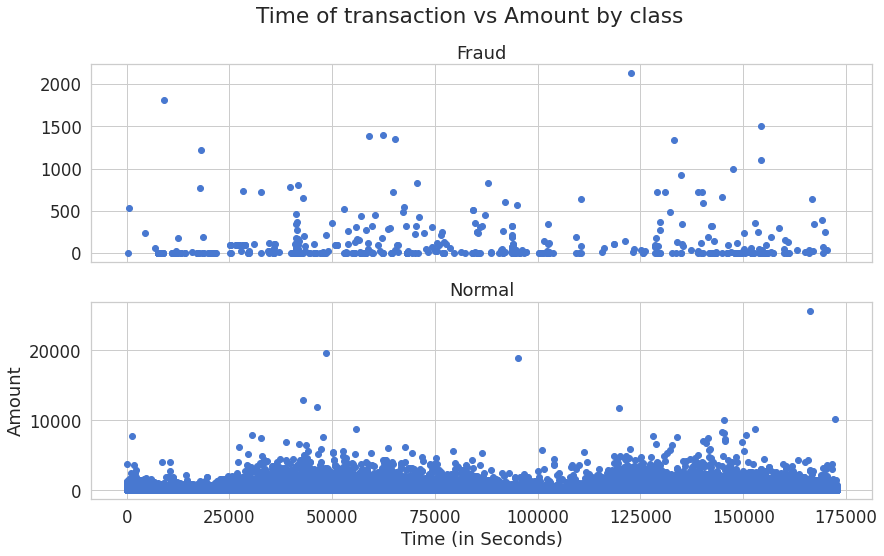

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Counter, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Counter
            , normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

So, it is clear that time of transaction has no bearing on the fraudulent activity.

## Preprocessing

Since, as shown above, time of transaction has no bearing on fraudulent activity, this feature is not going to contribute to model learning. Hence we can drop it. 

In [16]:
transactionData = df.drop(['Counter', 'customer_id', 'transaction_date'], axis=1)
transactionData

scaler =StandardScaler()

feature=transactionData.Amount
print(feature)
feature = scaler.fit_transform(feature.values.reshape(-1,1))
print(feature)
 

pickle.dump(scaler, open('/sasinside/userdata/gegrab/resources/hmeq/fraud_pytorch_scaler.pickle', 'wb'))

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284807, dtype: float64
[[ 0.24496426]
 [-0.34247454]
 [ 1.16068593]
 ...
 [-0.0818393 ]
 [-0.31324853]
 [ 0.51435531]]


Also let us standardize the feature Amount.

In [17]:
 
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1,1))
 
 


### Split the dataset in training and test datasets

We split the dataset as Training=80% and Test=20%. Training dataset will have only normal transactions and test dataset will have both normal and fraudulent transactions.

In [18]:
transactionData.iloc[43428]

 
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

gene = X_test.head()

X_train = X_train.values.astype('float32')
 
X_test = X_test.values.astype('float32')
y_test = y_test.values.astype('float32')
 

print(X_test[0])


[-16.526506     8.584971   -18.649853     9.505593   -13.793818
  -2.8324044  -16.701694     7.517344    -8.507059   -14.110185
   5.2992363  -10.834006     1.6711203   -9.373858     0.36080563
  -9.899246   -19.236292    -8.398552     3.1017354   -1.5149235
   1.1907387   -1.12767     -2.3585787    0.6734613   -1.4136996
  -0.46276236  -2.0185752   -1.0428041    1.1028336 ]


## Model
We will build the autoencoder consisting of 4 fully connected layers with 14,7,7,29 neurons. First 2 layers act as encoder and last 2 layers act as decoder. Note last layer has 29 nodes corresponding to 29 feature in the input data item.

In [19]:
transactionData

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0


In [20]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )
        
        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 29),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
model = Autoencoder()
#model = Autoencoder().float().cpu()
#model = Autoencoder().double().cpu()

In [22]:
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

In [23]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [24]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [26]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [27]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    

#torch.save(model.state_dict(), './credit_card_model.pth')


epoch [1/100], loss:0.7960
epoch [2/100], loss:0.7379
epoch [3/100], loss:0.7184
epoch [4/100], loss:0.7126
epoch [5/100], loss:0.7092
epoch [6/100], loss:0.7072
epoch [7/100], loss:0.7064
epoch [8/100], loss:0.7061
epoch [9/100], loss:0.7052
epoch [10/100], loss:0.7050
epoch [11/100], loss:0.7044
epoch [12/100], loss:0.7043
epoch [13/100], loss:0.7041
epoch [14/100], loss:0.7040
epoch [15/100], loss:0.7035
epoch [16/100], loss:0.7031
epoch [17/100], loss:0.7027
epoch [18/100], loss:0.7021
epoch [19/100], loss:0.7020
epoch [20/100], loss:0.7013
epoch [21/100], loss:0.7010
epoch [22/100], loss:0.7009
epoch [23/100], loss:0.7009
epoch [24/100], loss:0.7007
epoch [25/100], loss:0.7005
epoch [26/100], loss:0.7006
epoch [27/100], loss:0.7004
epoch [28/100], loss:0.7003
epoch [29/100], loss:0.7005
epoch [30/100], loss:0.7003
epoch [31/100], loss:0.7000
epoch [32/100], loss:0.7003
epoch [33/100], loss:0.7002
epoch [34/100], loss:0.7000
epoch [35/100], loss:0.7001
epoch [36/100], loss:0.7001
e

In [28]:
torch.save(model.state_dict(), '/sasinside/userdata/gegrab/resources/hmeq/credit_card_model.pth')
model3 = Autoencoder()
model3.load_state_dict(torch.load('/sasinside/userdata/gegrab/resources/hmeq/credit_card_model.pth'))
model3.eval()


 
 
X_test_var=torch.FloatTensor(X_test)
 
#X_test_var = torch.tensor(X_test)

 
with torch.no_grad():
    predict_proba =model3(X_test_var)
    predict_proba = torch.sigmoid(predict_proba)   
    #predict_proba = pd.DataFrame(predict_proba).astype("float")
    
    
print(predict_proba[:1])

 
 

tensor([[0.4838, 0.9440, 0.6654, 0.8877, 0.4999, 0.4991, 0.4946, 0.4988, 0.4978,
         0.5759, 0.4975, 0.4983, 0.5167, 0.5992, 0.4985, 0.5037, 0.5299, 0.4999,
         0.6717, 0.4911, 0.4982, 0.4982, 0.4993, 0.4980, 0.4999, 0.5109, 0.4999,
         0.4980, 0.4871]])


In [29]:
type(X_test_var)
X_test_var[0:2]

tensor([[-16.5265,   8.5850, -18.6499,   9.5056, -13.7938,  -2.8324, -16.7017,
           7.5173,  -8.5071, -14.1102,   5.2992, -10.8340,   1.6711,  -9.3739,
           0.3608,  -9.8992, -19.2363,  -8.3986,   3.1017,  -1.5149,   1.1907,
          -1.1277,  -2.3586,   0.6735,  -1.4137,  -0.4628,  -2.0186,  -1.0428,
           1.1028],
        [  0.3398,  -2.7437,  -0.1341,  -1.3857,  -1.4514,   1.0159,  -0.5244,
           0.2241,   0.8997,  -0.5650,  -0.0877,   0.9794,   0.0769,  -0.2179,
          -0.1368,  -2.1429,   0.1270,   1.7527,   0.4325,   0.5060,  -0.2134,
          -0.9425,  -0.5268,  -1.1570,   0.3112,  -0.7466,   0.0410,   0.1020,
           1.7263]])

In [30]:
 

import onnxruntime as rt
import onnx
torch.onnx.export(model,               # model being run
                  X_test_var[0],                         # model input (or a tuple for multiple inputs)
                  "/sasinside/userdata/gegrab/resources/hmeq/Fraud_PyTorch_ONNX.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to            
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'] # the model's output names
                 )



 
 

In [31]:
ort_session = rt.InferenceSession("/sasinside/userdata/gegrab/resources/hmeq/Fraud_PyTorch_ONNX.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(X_test_var[0])} 
ort_outs = torch.FloatTensor(ort_session.run(None, ort_inputs))
     
     
predict_proba = torch.sigmoid(ort_outs)   
predict_proba[0], X_test_var.shape

/tmp/ipykernel_25416/3812538038.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  ort_outs = torch.FloatTensor(ort_session.run(None, ort_inputs))


(tensor([0.4838, 0.9440, 0.6654, 0.8877, 0.4999, 0.4991, 0.4946, 0.4988, 0.4978,
         0.5759, 0.4975, 0.4983, 0.5167, 0.5992, 0.4985, 0.5037, 0.5299, 0.4999,
         0.6717, 0.4911, 0.4982, 0.4982, 0.4993, 0.4980, 0.4999, 0.5109, 0.4999,
         0.4980, 0.4871]),
 torch.Size([56962, 29]))

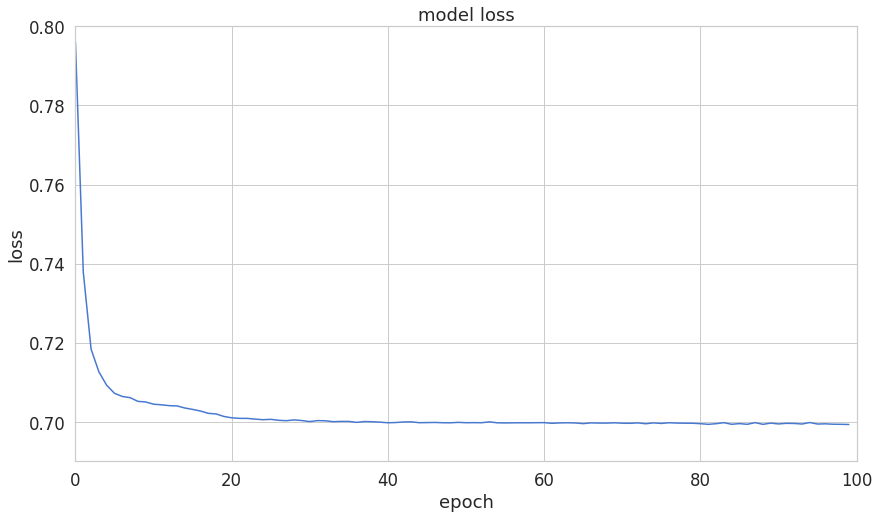

In [32]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.69,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Evaluation

In [33]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test




In [34]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,56962.000000
mean,0.730429,0.001720
std,3.491100,0.041443
min,0.045319,0.000000
25%,0.228199,0.000000
50%,0.374598,0.000000
75%,0.595581,0.000000
max,254.851410,1.000000


In [35]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,56962.000000
mean,0.730429,0.001720
std,3.491100,0.041443
min,0.045319,0.000000
25%,0.228199,0.000000
50%,0.374598,0.000000
75%,0.595581,0.000000
max,254.851410,1.000000


# Reconstruction Errors without Fraud

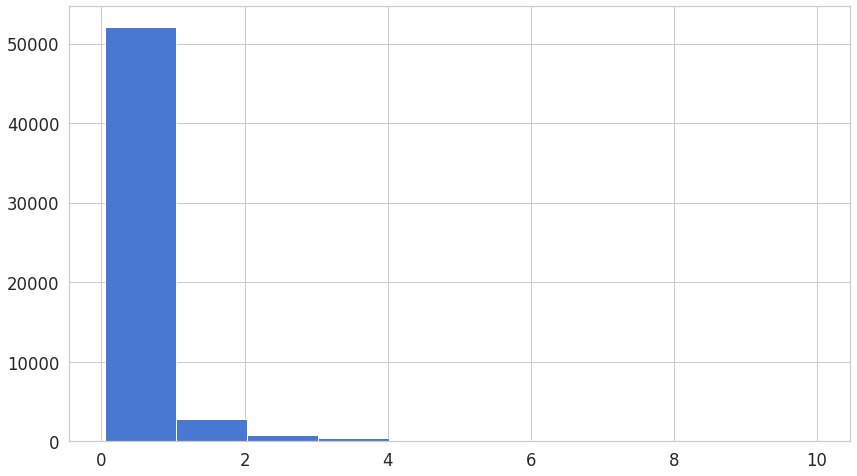

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

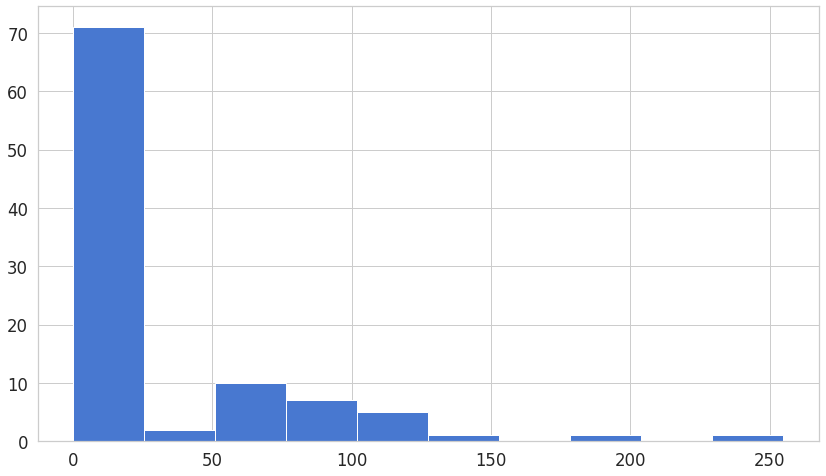

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

The receiver operating characteristics curve, or ROC curve for short are used very commonly for analysing the binary classifiers. It considers all possible thresholds for a given classifier and shows false positive rate (FPR) against true positive rates (TPR)


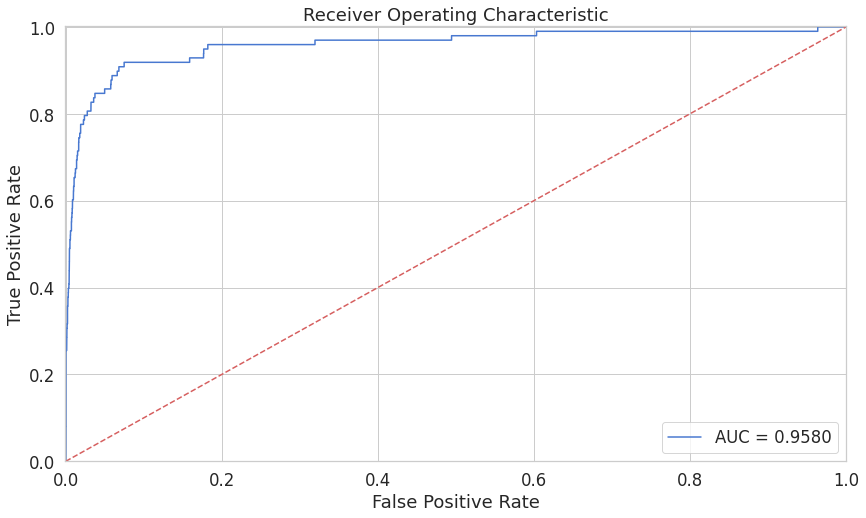

In [38]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

 

## Precision vs Recall

Setting a  threshold that is used to make a classification decision in a model is a way to adjust the trade-off of precision and recall for a given classifier.

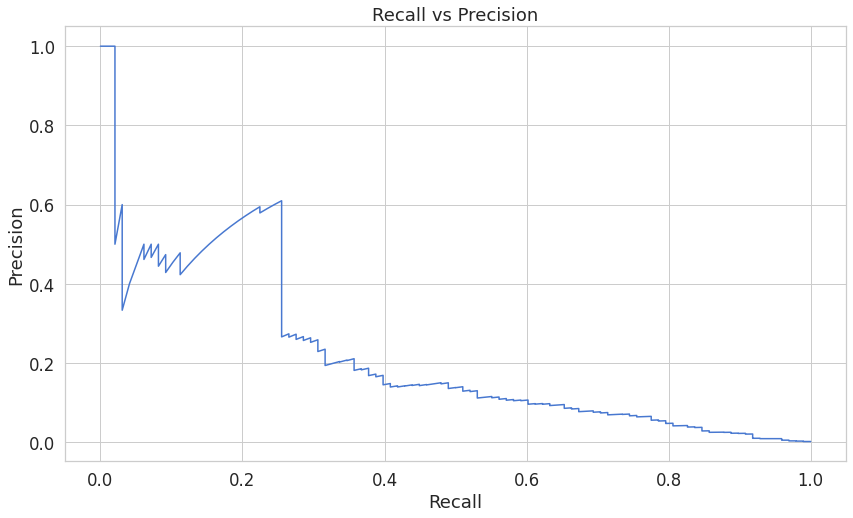

In [39]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

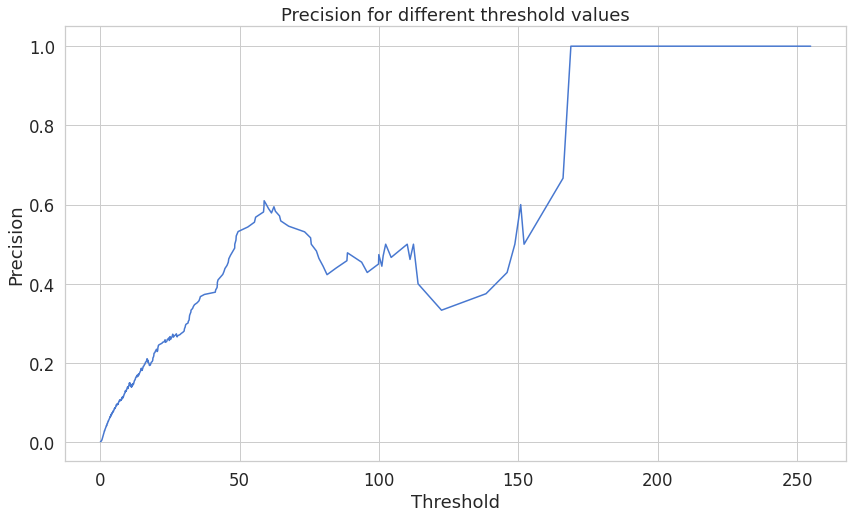

In [40]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:


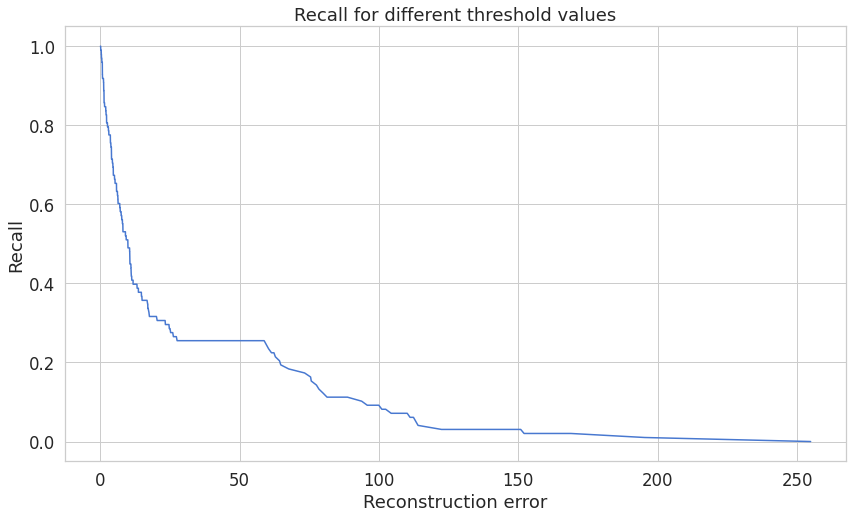

In [41]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

## Using the Model to make prediction

In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [42]:
 
# Use Tensorflow to calculate reconstruction errors
import tensorflow as tf
from tensorflow import keras

X_train_var=torch.FloatTensor(X_train)
 
 

 
with torch.no_grad():
    predict_proba2 =model(X_train_var)
    predict_proba2 = torch.sigmoid(predict_proba2)   
    #predict_proba2 = predict_proba2.numpy()
    
    
print(predict_proba2[:1])

 
reconstruction_errors = tf.keras.losses.msle(predict_proba2, X_train)

threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())

print(predict_proba2.shape)
print(X_train.shape)
print(reconstruction_errors.shape)
print(threshold)

pickle.dump(threshold, open('/sasinside/userdata/gegrab/resources/hmeq/fraud_anomaly_threshold.pickle', 'wb'))
# jack = pickle.load(open('./fraud_anomaly_threshold.pickle', 'rb'))    
# jack

tensor([[0.8745, 0.4841, 0.5012, 0.5754, 0.4996, 0.4922, 0.4924, 0.4990, 0.6880,
         0.4956, 0.6664, 0.8128, 0.7830, 0.4975, 0.4983, 0.6534, 0.4948, 0.6503,
         0.4950, 0.4966, 0.5405, 0.6970, 0.5548, 0.4968, 0.5343, 0.4990, 0.5028,
         0.4997, 0.4968]])
torch.Size([227451, 29])
(227451, 29)
(227451,)
0.16710247


2022-06-13 16:04:25.724587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-13 16:04:25.724628: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-13 16:04:25.724656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eeclxvm068.exnet.sas.com): /proc/driver/nvidia/version does not exist
2022-06-13 16:04:25.725096: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
threshold = 2.9

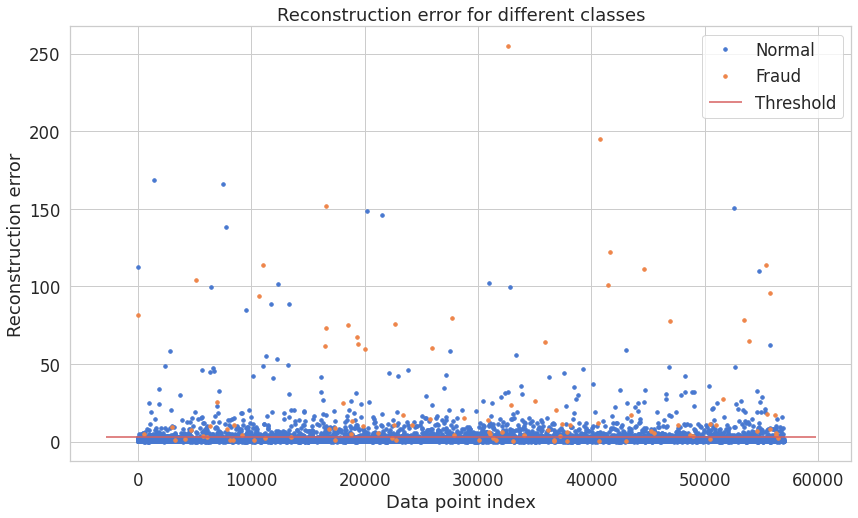

In [44]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

 Let's have a look at the confusion matrix:

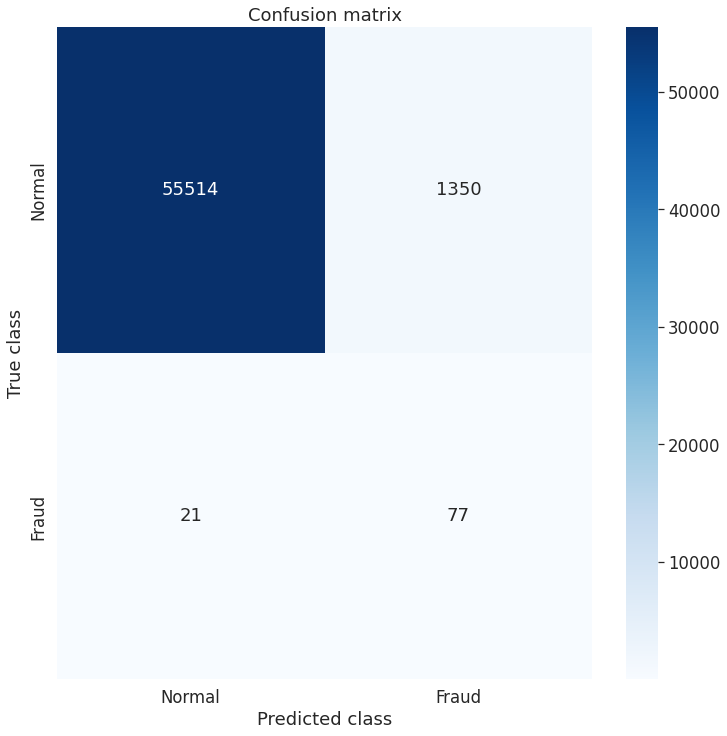

In [45]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. But the number of normal transactions classified as frauds is really high.  One can tweak the threshold here and there to come up with better results.

## Conclusion

We've created a very simple Deep Autoencoder in PyTorch that can reconstruct what non fraudulent transactions looks like. It has learnt to recognise the non fraudulent transactions by learning some patterns present in the those transactions, what those patterns are that is hard to tell - a mystery of any deep learning neural network.

PyTorch gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. One can attempt building the similar autoencoder using a different framework e.g like Tensorflow/Keras/fast.ai for a different domain/problem e.g classifying images as containing inappropriate content

In [46]:
input_params = ''
for col in df.columns:
    input_params += col
    if col != df.columns[-1]:
        input_params += ', '

input_cols = ''
for col in df.columns:
    input_cols += "\"" + col + "\""
    if col != df.columns[-1]:
        input_cols += ', '


print(input_cols)
print("")
print(input_params)

"customer_id", "transaction_date", "Counter", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount", "Class"

customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class


In [47]:
type(X_train)

numpy.ndarray

In [91]:
def scorePyTorch(customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount):
    "Output: FRAUD_FLAG, errors, threshold, max_credit_flag"
    
    import pickle
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from tensorflow import keras
    import onnxruntime as rt
    
    from torch.autograd import Variable
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
    import torch.utils.data as data_utils
    
    
    inputArray = pd.DataFrame([[customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount]],
                              columns = ["customer_id", "transaction_date","Counter", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"]
                               )

    scaler2 = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/fraud_pytorch_scaler.pickle', 'rb'))
    
    feature2 = inputArray.Amount
    inputArray.drop(['Amount', 'Counter', 'customer_id','transaction_date'], axis=1, inplace=True)
    #inputArray.drop('Counter',axis=1, inplace=True)
    
   
    AmountScaled = pd.DataFrame(scaler2.transform(feature2.values.reshape(-1,1)))
    inputArray.insert(28, 'Amount', AmountScaled)
    
    inputTensor=inputArray.values
     
      
    inputTensor =torch.FloatTensor(inputTensor)     
        
    
    ort_session = rt.InferenceSession("/sasinside/userdata/gegrab/resources/hmeq/Fraud_PyTorch_ONNX.onnx")

    def to_numpy(tensor):
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inputTensor[0])} 
    ort_outs = torch.FloatTensor(ort_session.run(None, ort_inputs))
     
     
    predict_probax = torch.sigmoid(ort_outs) 
    
    threshold = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/fraud_anomaly_threshold.pickle', 'rb'))    
    #print(threshold)
    
    

 
    reconstruction_errors = tf.keras.losses.msle(predict_probax, inputTensor)
    
    features= np.subtract(predict_probax, inputTensor)**2
    features= features.numpy()
     
    credit_flag= 'V' + str(int(np.where(features ==np.amax(features))[1])) 
     
    
    #print((reconstruction_errors))
    
    anomaly_mask = pd.Series(reconstruction_errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    
    FRAUD_FLAG =float(preds)
    errors=float(reconstruction_errors)
    threshold=float(threshold)
    
    if FRAUD_FLAG == 1:
        max_credit_flag = credit_flag
    else:
        max_credit_flag= ' '
     
    
     
    
    
    return (FRAUD_FLAG, errors, threshold, max_credit_flag)

In [93]:
import pandas as pd
X_test2 = pd.read_csv('Data_orig/creditcard_fraud_test_1.csv')

 
for i in range(10):
    print(scorePyTorch(**X_test2.iloc[i]))
 

 

(0.0, 0.12406211346387863, 0.16710247099399567, ' ')
(0.0, 0.11259195953607559, 0.16710247099399567, ' ')
(0.0, 0.1219252198934555, 0.16710247099399567, ' ')
(0.0, 0.1416078805923462, 0.16710247099399567, ' ')
(0.0, 0.0884949266910553, 0.16710247099399567, ' ')
(1.0, 0.2013453096151352, 0.16710247099399567, 'V13')
(1.0, 0.1737823635339737, 0.16710247099399567, 'V1')
(1.0, 0.18359452486038208, 0.16710247099399567, 'V11')
(1.0, 0.21466198563575745, 0.16710247099399567, 'V16')
(1.0, 0.344242662191391, 0.16710247099399567, 'V13')


In [94]:
score_code = """
def scorePyTorch(customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount):
    "Output: FRAUD_FLAG, errors, threshold, max_credit_flag"
    
    import pickle
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from tensorflow import keras
    import onnxruntime as rt
    
    from torch.autograd import Variable
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
    import torch.utils.data as data_utils
    
    
    inputArray = pd.DataFrame([[customer_id, transaction_date, Counter, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount]],
                              columns = ["customer_id", "transaction_date","Counter", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"]
                               )

    scaler2 = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/fraud_pytorch_scaler.pickle', 'rb'))
    
    feature2 = inputArray.Amount
    inputArray.drop(['Amount', 'Counter', 'customer_id','transaction_date'], axis=1, inplace=True)
    #inputArray.drop('Counter',axis=1, inplace=True)
    
   
    AmountScaled = pd.DataFrame(scaler2.transform(feature2.values.reshape(-1,1)))
    inputArray.insert(28, 'Amount', AmountScaled)
    
    inputTensor=inputArray.values
     
      
    inputTensor =torch.FloatTensor(inputTensor)     
        
    
    ort_session = rt.InferenceSession("/sasinside/userdata/gegrab/resources/hmeq/Fraud_PyTorch_ONNX.onnx")

    def to_numpy(tensor):
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inputTensor[0])} 
    ort_outs = torch.FloatTensor(ort_session.run(None, ort_inputs))
     
     
    predict_probax = torch.sigmoid(ort_outs) 
    
    threshold = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/fraud_anomaly_threshold.pickle', 'rb'))    
    #print(threshold)
    
    

 
    reconstruction_errors = tf.keras.losses.msle(predict_probax, inputTensor)
    
    features= np.subtract(predict_probax, inputTensor)**2
    features= features.numpy()
     
    credit_flag= 'V' + str(int(np.where(features ==np.amax(features))[1])) 
     
    
    #print((reconstruction_errors))
    
    anomaly_mask = pd.Series(reconstruction_errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    
    FRAUD_FLAG =float(preds)
    errors=float(reconstruction_errors)
    threshold=float(threshold)
    
    if FRAUD_FLAG == 1:
        max_credit_flag = credit_flag
    else:
        max_credit_flag= ' '
     
    
     
    
    
    return (FRAUD_FLAG, errors, threshold, max_credit_flag)"""

f = open('Data_orig/Pytorch_Credit_Card_Fraud_ONNX_MAX.py',"w+")
f.write(score_code)
f.close()